<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Isolation Forest Anomalies Removal
</p>

In [2]:
# === Libraries ===
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualizations
import seaborn as sns  # For enhanced data visualizations
from sklearn.ensemble import IsolationForest  # For anomaly detection in datasets
from sklearn.preprocessing import StandardScaler  # For standardizing features

# For inline plots within Jupyter Notebook
%matplotlib inline

In [3]:
# Load Data
data = pd.read_csv('aggregated_measurements_data.csv')

In [4]:
# Data Preprocessing/Cleaning

## Parse Dates
data['time'] = pd.to_datetime(data['time'], utc=True)

# Capture rows before excluding SF11 and SF12
rows_before_sf_exclusion = len(data)

# Exclude SF11 and SF12 datapoints
data = data[~data['SF'].isin([11, 12])]

# Capture rows after excluding SF11 and SF12
rows_after_sf_exclusion = len(data)

# Calculate removed rows and percentage
rows_removed_sf = rows_before_sf_exclusion - rows_after_sf_exclusion
percentage_removed_sf = (rows_removed_sf / rows_before_sf_exclusion) * 100

# Display SF exclusion results
print("---- SF11 and SF12 Exclusion ----")
print(f"Rows before exclusion: {rows_before_sf_exclusion}")
print(f"Rows removed: {rows_removed_sf} ({percentage_removed_sf:.2f}%)\n")

## Convert object columns to numeric where possible
numeric_columns = data.select_dtypes(include=['object', 'string']).columns
for col in numeric_columns:
    if col != 'device_id':
        data[col] = pd.to_numeric(data[col], errors='coerce')

## Reset the index to have 'time' as a column again
data.reset_index(inplace=True)

# Total number of rows
total_rows = len(data)

# Identify rows with any NaN or Inf values
rows_with_nan = data.isnull().any(axis=1)
rows_with_inf = data.isin([np.inf, -np.inf]).any(axis=1)
rows_with_issues = rows_with_nan | rows_with_inf

# Count the number of affected rows
affected_rows = rows_with_issues.sum()

# Calculate the percentage of affected rows
affected_percentage = (affected_rows / total_rows) * 100

# Display the results
print("---- NaN and Inf Removal ----")
print(f"Total number of rows: {total_rows}")
print(f"Rows with NaN or Inf: {affected_rows} ({affected_percentage:.2f}%)\n")

# ---- Dropping Affected Rows ----

# Drop the affected rows and reset the index
df = data[~rows_with_issues].reset_index(drop=True)

# Final number of rows after cleaning
final_rows = len(df)
final_percentage = (final_rows / total_rows) * 100

print("---- Final Cleaned Data ----")
print(f"Rows after cleaning: {final_rows} ({final_percentage:.2f}%)\n")

# ---- Summary of All Removals ----

# Total rows removed from SF exclusion and NaN/Inf removal
total_rows_removed = rows_removed_sf + affected_rows
total_percentage_removed = (total_rows_removed / rows_before_sf_exclusion) * 100

print("---- Summary of Data Cleaning ----")
print(f"Total rows before any cleaning: {rows_before_sf_exclusion}")
print(f"Total rows removed: {total_rows_removed} ({total_percentage_removed:.2f}%)")
print(f"Total rows after cleaning: {final_rows} ({final_percentage:.2f}%)")


---- SF11 and SF12 Exclusion ----
Rows before exclusion: 524567
Rows removed: 148772 (28.36%)

---- NaN and Inf Removal ----
Total number of rows: 375795
Rows with NaN or Inf: 357 (0.09%)

---- Final Cleaned Data ----
Rows after cleaning: 375438 (99.91%)

---- Summary of Data Cleaning ----
Total rows before any cleaning: 524567
Total rows removed: 149129 (28.43%)
Total rows after cleaning: 375438 (99.91%)


In [5]:
# Anomaly Detection Per Device

# Set desired contamination level
contamination_level = 0.01  # 1% of data points considered anomalies

# Initialize lists to store statistics
device_stats = []

# Anomaly Detection Function with Selected Features
def detect_anomalies_per_device(device_data, contamination=contamination_level):
    # Sort by 'time' to maintain chronological order
    device_data = device_data.sort_values('time').reset_index(drop=True)
    
    # Feature Selection - Use only the selected sensor data
    features = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'rssi', 'snr']
    
    # Ensure all features are numeric
    for col in features:
        device_data[col] = pd.to_numeric(device_data[col], errors='coerce')
    
    # Drop any remaining rows with NaN values in features
    device_data.dropna(subset=features, inplace=True)
    
    # Check if there's enough data to proceed
    if device_data.shape[0] < 1:
        print("Not enough data to process for this device.")
        return pd.DataFrame(), {}
    
    # Feature Scaling
    X = device_data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize Isolation Forest with custom contamination
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the model
    iso_forest.fit(X_scaled)
    
    # Predict anomalies
    device_data['anomaly_score'] = iso_forest.decision_function(X_scaled)
    device_data['anomaly'] = iso_forest.predict(X_scaled)
    device_data['anomaly_label'] = device_data['anomaly'].map({1: 'Normal', -1: 'Anomaly'})
    
    # Collect statistics
    total_points = len(device_data)
    anomalies_count = (device_data['anomaly'] == -1).sum()
    anomaly_percentage = (anomalies_count / total_points) * 100
    
    stats = {
        'device_id': device_data['device_id'].iloc[0],
        'total_points': total_points,
        'anomalies_detected': anomalies_count,
        'anomaly_percentage': anomaly_percentage
    }
    
    return device_data, stats

# Apply Function to Each Device
device_ids = data['device_id'].unique()
results = []
device_stats = []

for device_id in device_ids:
    print(f"Processing data for: {device_id}")
    device_data = data[data['device_id'] == device_id]
    
    # Skip if device_data is empty
    if device_data.empty:
        print(f"No data for device {device_id}. Skipping.")
        continue
    
    device_analyzed, stats = detect_anomalies_per_device(device_data, contamination=contamination_level)
    
    # Only append if the result is not empty
    if not device_analyzed.empty:
        results.append(device_analyzed)
        device_stats.append(stats)
    else:
        print(f"No valid data to process for device {device_id}.")

# Combine Results
if results:
    data_with_anomalies = pd.concat(results, ignore_index=True)
    
    # Separate anomalies and normal data
    anomalies = data_with_anomalies[data_with_anomalies['anomaly'] == -1]
    cleaned_data = data_with_anomalies[data_with_anomalies['anomaly'] == 1]
    
    # Create a DataFrame for device statistics
    stats_df = pd.DataFrame(device_stats)
    
    # Calculate combined statistics for the entire dataset
    total_points_all = stats_df['total_points'].sum()
    anomalies_detected_all = stats_df['anomalies_detected'].sum()
    anomaly_percentage_all = (anomalies_detected_all / total_points_all) * 100
    
    combined_stats = {
        'total_points_all': total_points_all,
        'anomalies_detected_all': anomalies_detected_all,
        'anomaly_percentage_all': anomaly_percentage_all
    }
    
    # Print combined statistics
    print(f"Total data points processed: {combined_stats['total_points_all']}")
    print(f"Total anomalies detected: {combined_stats['anomalies_detected_all']}")
    print(f"Overall anomaly percentage: {combined_stats['anomaly_percentage_all']:.2f}%")
else:
    print("No valid data was processed for any device.")

stats_df

Processing data for: ED3
Processing data for: ED0
Processing data for: ED1
Processing data for: ED2
Processing data for: ED4
Processing data for: ED5
Total data points processed: 375438
Total anomalies detected: 3757
Overall anomaly percentage: 1.00%


,device_id,total_points,anomalies_detected,anomaly_percentage
0,ED3,62241,623,1.000948
1,ED0,62496,625,1.000064
2,ED1,62331,624,1.001107
3,ED2,62457,625,1.000688
4,ED4,62033,621,1.001080
5,ED5,63880,639,1.000313


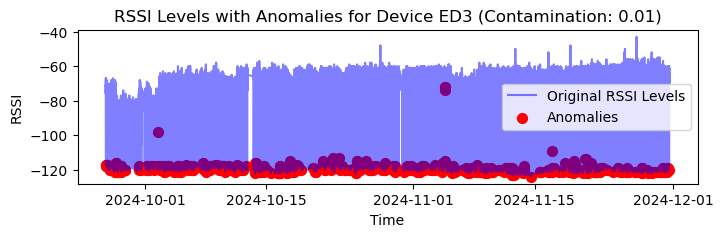

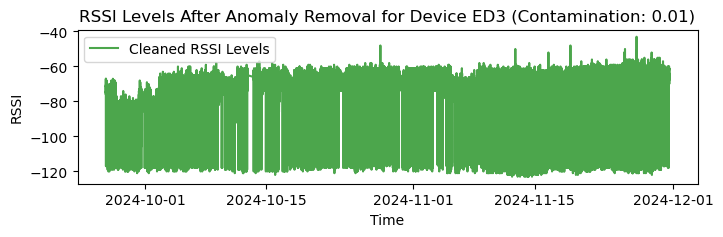

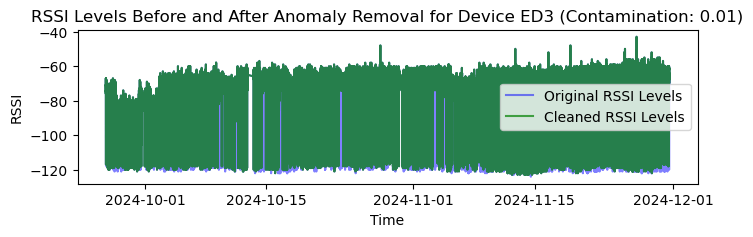

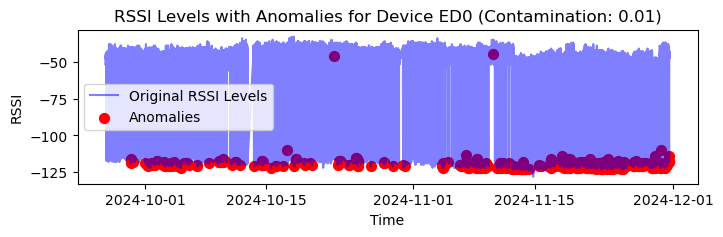

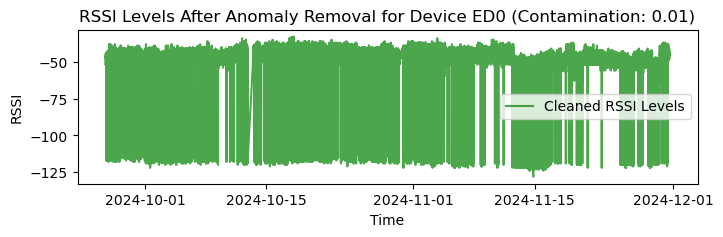

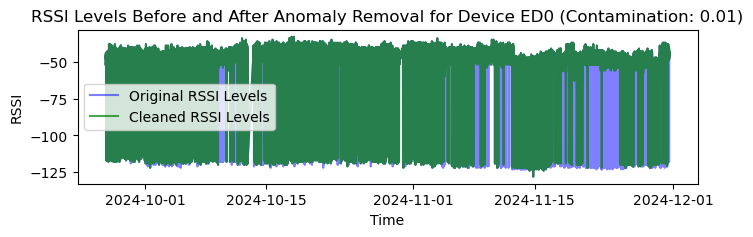

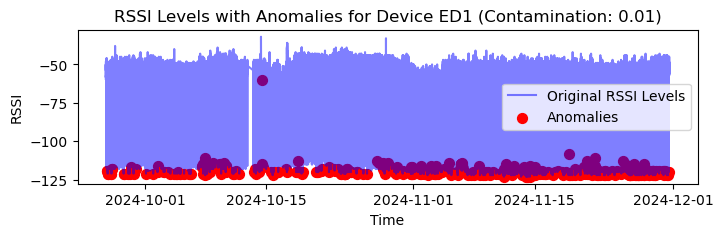

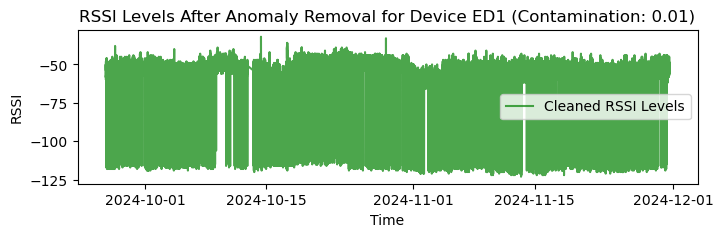

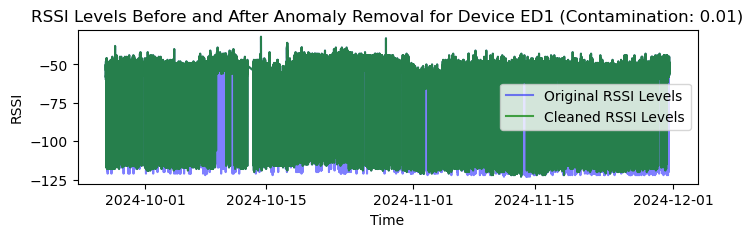

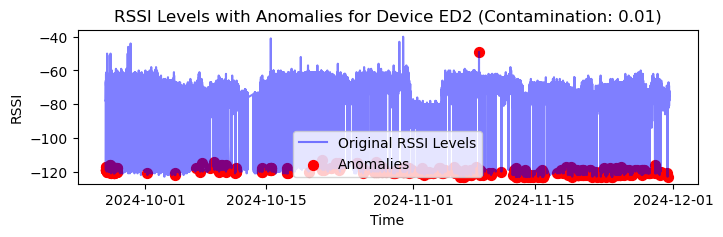

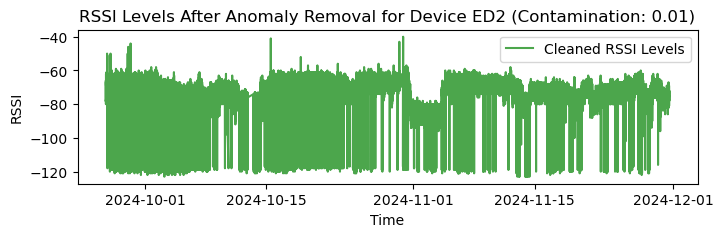

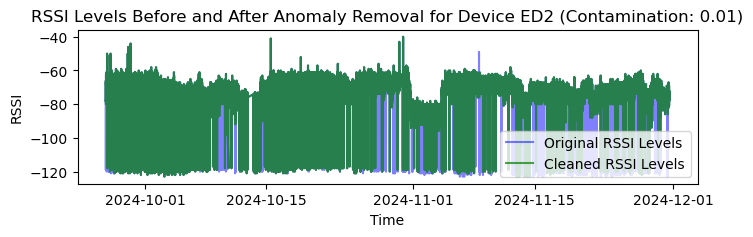

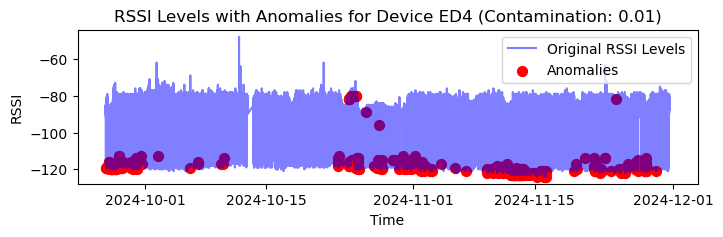

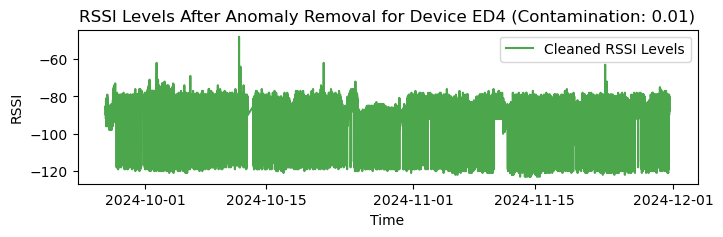

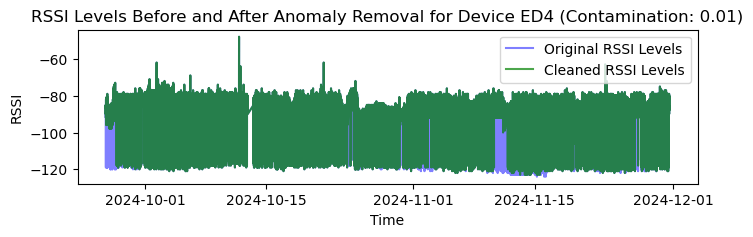

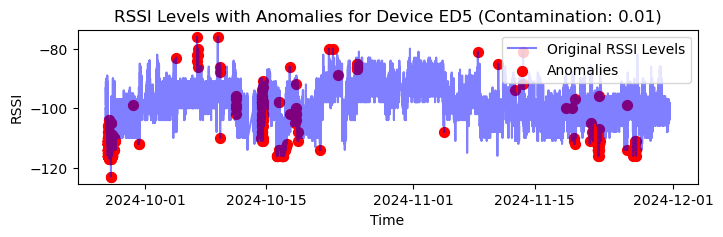

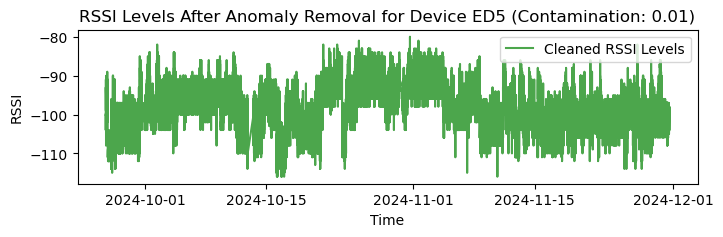

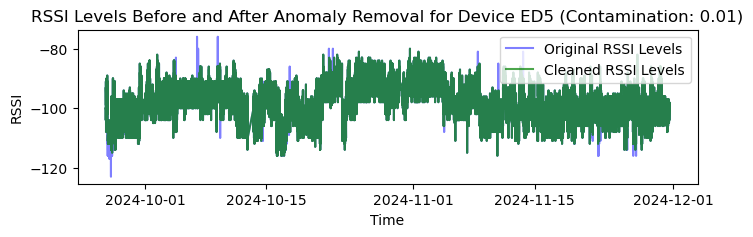

In [6]:
# Data Visualization
# Plot RSSI Levels Before and After Anomaly Removal for Each Device
#CAN BE ANY OTHER VARIABLE

if results:
    for device_id in device_ids:
        device_original = data[data['device_id'] == device_id]
        device_cleaned = cleaned_data[cleaned_data['device_id'] == device_id]
        device_anomalies = anomalies[anomalies['device_id'] == device_id]
        
        if device_original.empty or device_cleaned.empty:
            print(f"Insufficient data to plot for device {device_id}.")
            continue
        
        # Before anomaly removal
        plt.figure(figsize=(8, 2))
        plt.plot(device_original['time'], device_original['rssi'], label='Original RSSI Levels', color='blue', alpha=0.5)
        if not device_anomalies.empty:
            plt.scatter(device_anomalies['time'], device_anomalies['rssi'], color='red', label='Anomalies', s=50)
        plt.xlabel('Time')
        plt.ylabel('RSSI')
        plt.title(f'RSSI Levels with Anomalies for Device {device_id} (Contamination: {contamination_level})')
        plt.legend()
        plt.show()
        
        # After anomaly removal
        plt.figure(figsize=(8, 2))
        plt.plot(device_cleaned['time'], device_cleaned['rssi'], label='Cleaned RSSI Levels', color='green', alpha=0.7)
        plt.xlabel('Time')
        plt.ylabel('RSSI')
        plt.title(f'RSSI Levels After Anomaly Removal for Device {device_id} (Contamination: {contamination_level})')
        plt.legend()
        plt.show()
        
        # Before and after on the same axis
        plt.figure(figsize=(8, 2))
        plt.plot(device_original['time'], device_original['rssi'], label='Original RSSI Levels', color='blue', alpha=0.5)
        plt.plot(device_cleaned['time'], device_cleaned['rssi'], label='Cleaned RSSI Levels', color='green', alpha=0.7)
        plt.xlabel('Time')
        plt.ylabel('RSSI')
        plt.title(f'RSSI Levels Before and After Anomaly Removal for Device {device_id} (Contamination: {contamination_level})')
        plt.legend()
        plt.show()
else:
    print("No data available for plotting.")

In [7]:
# Save Cleaned Data; Anomalies weg :)
if 'cleaned_data' in locals():
    cleaned_data.to_csv('../all_data_files/cleaned_dataset_per_device.csv', index=False)
    print("Cleaned data saved to 'cleaned_dataset_per_device.csv'.")
else:
    print("No cleaned data to save.")

Cleaned data saved to 'cleaned_dataset_per_device.csv'.
